# ⭐ GOLD LAYER - Modèle Dimensionnel (Star Schema)

**Flux ETL** : Bronze (brut) → Silver (nettoyé) → **Gold (métier)**

**Auteurs** : Nejma MOUALHI | Brieuc OLIVIERI | Nicolas TAING

---

## 🎯 Objectifs

### Créer un modèle en étoile (Star Schema) optimisé :
1. **5 Dimensions** : Temps, Patient, Diagnostic, Professionnel, Établissement
2. **4 Tables de Faits** : Consultations, Hospitalisations, Décès, Satisfaction
3. **Partitionnement** temporel (année/mois)
4. **Optimisations** Spark SQL

## 📊 Architecture du modèle

```
         dim_temps
             |
dim_patient --+-- FAIT_CONSULTATION -- dim_professionnel
             |
        dim_diagnostic
             |
      dim_etablissement
```

In [17]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, countDistinct, min, max, sum, avg,
    year, month, dayofmonth, date_format,
    unix_timestamp, monotonically_increasing_id,
    lit, when, coalesce
)
from pyspark.sql.types import *
from datetime import datetime, timedelta
import time

print("✅ Imports OK")

✅ Imports OK


In [18]:
# Configuration Spark avec optimisations avancées
spark = SparkSession.builder \
    .appName("CHU_Gold_Star_Schema") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.sql.autoBroadcastJoinThreshold", "10485760") \
    .getOrCreate()

print(f"✅ Spark {spark.version} démarré avec optimisations")

# Chemins - LECTURE DEPUIS SILVER (données nettoyées)
SILVER_BASE = "/home/jovyan/data/silver"
GOLD_OUTPUT = "/home/jovyan/data/gold"

print(f"📖 Source: {SILVER_BASE} (SILVER - données nettoyées)")
print(f"⭐ Destination: {GOLD_OUTPUT}")

✅ Spark 3.5.0 démarré avec optimisations
📖 Source: /home/jovyan/data/silver (SILVER - données nettoyées)
⭐ Destination: /home/jovyan/data/gold


---

## 🔷 ÉTAPE 1 : Création des Dimensions

Les dimensions contiennent les attributs descriptifs pour l'analyse.

In [19]:
# 1.1 DIMENSION TEMPS (générée, pas depuis Silver)
print("="*80)
print("🔷 DIMENSION: dim_temps")
print("="*80)

# Créer une dimension temps complète (2013-2025)
start_date = datetime(2013, 1, 1)
end_date = datetime(2025, 12, 31)
dates = []

current = start_date
while current <= end_date:
    dates.append((
        current.strftime("%Y%m%d"),     # id_temps (20250121)
        current,                          # date
        current.year,                     # annee
        current.month,                    # mois
        (current.month - 1) // 3 + 1,     # trimestre
        current.strftime("%A"),           # jour_semaine (Monday, Tuesday...)
        current.strftime("%B"),           # nom_mois (January, February...)
        current.weekday() >= 5,           # est_weekend
        current.weekday()                 # numero_jour_semaine (0=Monday)
    ))
    current += timedelta(days=1)

schema_temps = StructType([
    StructField("id_temps", StringType(), False),
    StructField("date", DateType(), False),
    StructField("annee", IntegerType(), False),
    StructField("mois", IntegerType(), False),
    StructField("trimestre", IntegerType(), False),
    StructField("jour_semaine", StringType(), True),
    StructField("nom_mois", StringType(), True),
    StructField("est_weekend", BooleanType(), True),
    StructField("numero_jour_semaine", IntegerType(), True)
])

dim_temps = spark.createDataFrame(dates, schema=schema_temps)

print(f"✅ {dim_temps.count():,} jours créés (2013-2025)")
dim_temps.show(5)

# Sauvegarde avec partitionnement par année
dim_temps.write \
    .mode("overwrite") \
    .partitionBy("annee") \
    .parquet(f"{GOLD_OUTPUT}/dim_temps")

print(f"💾 Sauvegardé: {GOLD_OUTPUT}/dim_temps (partitionné par annee)")

🔷 DIMENSION: dim_temps
✅ 4,748 jours créés (2013-2025)
+--------+----------+-----+----+---------+------------+--------+-----------+-------------------+
|id_temps|      date|annee|mois|trimestre|jour_semaine|nom_mois|est_weekend|numero_jour_semaine|
+--------+----------+-----+----+---------+------------+--------+-----------+-------------------+
|20130101|2013-01-01| 2013|   1|        1|     Tuesday| January|      false|                  1|
|20130102|2013-01-02| 2013|   1|        1|   Wednesday| January|      false|                  2|
|20130103|2013-01-03| 2013|   1|        1|    Thursday| January|      false|                  3|
|20130104|2013-01-04| 2013|   1|        1|      Friday| January|      false|                  4|
|20130105|2013-01-05| 2013|   1|        1|    Saturday| January|       true|                  5|
+--------+----------+-----+----+---------+------------+--------+-----------+-------------------+
only showing top 5 rows

💾 Sauvegardé: /home/jovyan/data/gold/dim_temps 

In [20]:
# 1.2 DIMENSION PATIENT (depuis SILVER)
print("\n" + "="*80)
print("🔷 DIMENSION: dim_patient")
print("="*80)

# Charger depuis SILVER (données déjà anonymisées et nettoyées)
df_patient_silver = spark.read.parquet(f"{SILVER_BASE}/patient")

# Sélection pour dimension (déjà propre depuis Silver)
dim_patient = df_patient_silver.select(
    col("id_patient"),
    col("nom_hash"),         # Déjà anonymisé en Silver
    col("prenom_hash"),      # Déjà anonymisé en Silver
    col("sexe"),
    col("age"),
    col("date_naissance"),   # Déjà formaté en Silver
    col("ville"),
    col("code_postal"),
    col("pays"),
    col("groupe_sanguin")
)

print(f"✅ {dim_patient.count():,} patients")
dim_patient.show(5, truncate=False)

# Sauvegarde
dim_patient.write \
    .mode("overwrite") \
    .parquet(f"{GOLD_OUTPUT}/dim_patient")

print(f"💾 Sauvegardé: {GOLD_OUTPUT}/dim_patient")


🔷 DIMENSION: dim_patient
✅ 100,000 patients
+----------+----------------------------------------------------------------+----------------------------------------------------------------+------+---+--------------+--------------------+-----------+----+--------------+
|id_patient|nom_hash                                                        |prenom_hash                                                     |sexe  |age|date_naissance|ville               |code_postal|pays|groupe_sanguin|
+----------+----------------------------------------------------------------+----------------------------------------------------------------+------+---+--------------+--------------------+-----------+----+--------------+
|5         |d34db878e3724987c7853288b3744ddba9620358185f8b65822014cd45a855ab|d888938a8847ae08380fefffd5d72ae0e3483ed5d312f06b4b259817d15d75d0|male  |55 |1965-10-04    |LES LILAS           |93260      |FR  |O+            |
|15        |7c4732648c9b5c5c5e83cc2b6d2f7e628d369593e45e37caf95d3f6

In [21]:
# 1.3 DIMENSION DIAGNOSTIC (depuis SILVER)
print("\n" + "="*80)
print("🔷 DIMENSION: dim_diagnostic")
print("="*80)

df_diagnostic_silver = spark.read.parquet(f"{SILVER_BASE}/diagnostic")

# Vérifier les colonnes disponibles
print(f"Colonnes disponibles: {df_diagnostic_silver.columns}")

dim_diagnostic = df_diagnostic_silver.select(
    col("Code_diag").alias("code_diag"),
    col("Diagnostic").alias("libelle"),
    # Ajout catégorie CIM-10 (première lettre du code)
    col("Code_diag").substr(1, 1).alias("categorie")
).dropDuplicates(["code_diag"])

print(f"✅ {dim_diagnostic.count():,} diagnostics")
dim_diagnostic.show(5, truncate=False)

dim_diagnostic.write \
    .mode("overwrite") \
    .parquet(f"{GOLD_OUTPUT}/dim_diagnostic")

print(f"💾 Sauvegardé: {GOLD_OUTPUT}/dim_diagnostic")


🔷 DIMENSION: dim_diagnostic
Colonnes disponibles: ['Code_diag', 'Diagnostic', 'ingestion_timestamp', 'ingestion_date', 'transformation_timestamp']
✅ 15,490 diagnostics
+---------+---------------------------------------------+---------+
|code_diag|libelle                                      |categorie|
+---------+---------------------------------------------+---------+
|A000     |Cholera e Vibrio cholerae 01, biovar cholerae|A        |
|A001     |Cholera e Vibrio cholerae 01, biovar eltor   |A        |
|A009     |Cholera, sans precision                      |A        |
|A010     |Fievre typhoede                              |A        |
|A011     |Paratyphoede A                               |A        |
+---------+---------------------------------------------+---------+
only showing top 5 rows

💾 Sauvegardé: /home/jovyan/data/gold/dim_diagnostic


In [22]:
# 1.4 DIMENSION PROFESSIONNEL (depuis SILVER)
print("\n" + "="*80)
print("🔷 DIMENSION: dim_professionnel")
print("="*80)

df_prof_silver = spark.read.parquet(f"{SILVER_BASE}/professionnel_de_sante")

# Vérifier colonnes
print(f"Colonnes disponibles: {df_prof_silver.columns}")

dim_professionnel = df_prof_silver.select(
    col("Identifiant").alias("id_prof"),
    col("Nom").alias("nom"),
    col("Prenom").alias("prenom"),
    col("Code_specialite").alias("code_specialite")
).dropDuplicates(["id_prof"])

# Jointure avec spécialités (depuis Silver)
df_spec_silver = spark.read.parquet(f"{SILVER_BASE}/specialites")
print(f"Colonnes spécialités: {df_spec_silver.columns}")

dim_professionnel = dim_professionnel.join(
    df_spec_silver.select(
        col("Code_specialite"),
        col("Specialite").alias("nom_specialite")
    ),
    on="code_specialite",
    how="left"
)

print(f"✅ {dim_professionnel.count():,} professionnels")
dim_professionnel.show(5, truncate=False)

dim_professionnel.write \
    .mode("overwrite") \
    .parquet(f"{GOLD_OUTPUT}/dim_professionnel")

print(f"💾 Sauvegardé: {GOLD_OUTPUT}/dim_professionnel")


🔷 DIMENSION: dim_professionnel
Colonnes disponibles: ['Identifiant', 'Civilite', 'Categorie_professionnelle', 'Nom', 'Prenom', 'Profession', 'Type_identifiant', 'Code_specialite', 'ingestion_timestamp', 'ingestion_date', 'transformation_timestamp']
Colonnes spécialités: ['Code_specialite', 'Fonction', 'Specialite', 'ingestion_timestamp', 'ingestion_date', 'transformation_timestamp']
✅ 1,048,575 professionnels
+---------------+---------+----------+-------+---------------------------+
|code_specialite|id_prof  |nom       |prenom |nom_specialite             |
+---------------+---------+----------+-------+---------------------------+
|ASS890091      |01A003753|CHAREYRE  |Laure  |Assistant de service social|
|ASS890091      |01A004124|CECCARELLI|Chantal|Assistant de service social|
|ASS890091      |01A004595|GREVOT    |Nicole |Assistant de service social|
|ASS890091      |01A004611|CONSTANS  |Josiane|Assistant de service social|
|ASS890091      |01A005105|MULLER    |Sylvie |Assistant de se

In [23]:
# 1.5 DIMENSION ETABLISSEMENT (depuis SILVER + enrichi avec DEPARTEMENTS)
print("\n" + "="*80)
print("🔷 DIMENSION: dim_etablissement (enrichie avec régions/départements)")
print("="*80)

df_etab_silver = spark.read.parquet(f"{SILVER_BASE}/etablissement_sante")

# Lire départements depuis Bronze
df_dept = spark.read.parquet("/home/jovyan/data/bronze/csv/departements")
print(f"📍 Départements chargés : {df_dept.count()} départements")

# Créer dimension de base
from pyspark.sql.functions import substring

dim_etablissement = df_etab_silver.select(
    col("finess_site").alias("finess"),
    col("siret_site").alias("siret"),
    col("raison_sociale").alias("nom"),
    col("commune").alias("ville"),
    col("code_postal"),
    col("telephone"),
    col("email"),
    # Extraire code département (2 premiers chiffres du code postal)
    substring(col("code_postal"), 1, 2).alias("code_departement")
).filter(
    col("finess").isNotNull()
).dropDuplicates(["finess"])

# Enrichir avec région/département
dim_etablissement = dim_etablissement.join(
    df_dept.select(
        col("num_departement"),
        col("libelle_departement"),
        col("libelle_region"),
        col("abv_region")
    ),
    dim_etablissement["code_departement"] == df_dept["num_departement"],
    "left"
)

print(f"✅ {dim_etablissement.count():,} établissements (enrichis avec régions)")
dim_etablissement.show(5, truncate=False)

dim_etablissement.write \
    .mode("overwrite") \
    .parquet(f"{GOLD_OUTPUT}/dim_etablissement")

print(f"💾 Sauvegardé: {GOLD_OUTPUT}/dim_etablissement")
print(f"   - Colonnes géographiques ajoutées: libelle_departement, libelle_region, abv_region")


🔷 DIMENSION: dim_etablissement (enrichie avec régions/départements)
📍 Départements chargés : 101 départements
✅ 200 établissements (enrichis avec régions)
+---------+-----+-------------------------------------+-------------------------+-----------+----------+-----+----------------+---------------+-------------------+--------------------+----------+
|finess   |siret|nom                                  |ville                    |code_postal|telephone |email|code_departement|num_departement|libelle_departement|libelle_region      |abv_region|
+---------+-----+-------------------------------------+-------------------------+-----------+----------+-----+----------------+---------------+-------------------+--------------------+----------+
|180036014|NULL |CHNO DES QUINZE-VINGTS PARIS         |PARIS 12E  ARRONDISSEMENT|75012      |0140021520|NULL |75              |75             |Paris              |Ile-de-France       |IDF       |
|200009181|NULL |CIAS AIME                            |AIME-

---

## 📊 ÉTAPE 2 : Création des Tables de Faits

Les faits contiennent les mesures et les clés étrangères vers les dimensions.

In [24]:
# 2.1 FAIT CONSULTATION (depuis SILVER)
print("\n" + "="*80)
print("📊 FAIT: fait_consultation")
print("="*80)

df_consultation_silver = spark.read.parquet(f"{SILVER_BASE}/consultation")

# Vérification des colonnes disponibles
print("📋 Colonnes disponibles dans consultation Silver:")
for col_name in df_consultation_silver.columns:
    print(f"  - {col_name}")
print()

# Transformation pour fait avec les colonnes correctes (selon l'erreur précédente)
fait_consultation = df_consultation_silver.select(
    col("id_consultation"),
    col("id_patient"),
    col("id_professionnel").alias("id_prof"),
    col("id_diagnostic").alias("code_diag"),
    col("id_mutuelle"),  # Correction: "id_mutuelle" au lieu de "id_salle"
    
    # Clé temporelle
    date_format(col("date_consultation"), "yyyyMMdd").alias("id_temps"),
    col("date_consultation"),
    
    # Dimensions temporelles (pour partitionnement)
    col("annee"),
    col("mois"),
    col("jour"),
    
    # Mesures disponibles (selon données Silver)
    col("heure_debut"),
    col("heure_fin"),
    col("motif")  # Correction: "motif" au lieu de "notes"
)

print(f"✅ {fait_consultation.count():,} consultations")
fait_consultation.show(5)

# Statistiques
print("\n📈 Statistiques:")
fait_consultation.select(
    count("*").alias("total_consultations"),
    countDistinct("id_patient").alias("patients_uniques"),
    countDistinct("id_prof").alias("professionnels_uniques"),
    min("annee").alias("annee_min"),
    max("annee").alias("annee_max")
).show()

# Sauvegarde avec PARTITIONNEMENT par année et mois
print("\n💾 Sauvegarde avec optimisations (partitionnement)...")
fait_consultation.write \
    .mode("overwrite") \
    .partitionBy("annee", "mois") \
    .parquet(f"{GOLD_OUTPUT}/fait_consultation")

print(f"✅ Sauvegardé: {GOLD_OUTPUT}/fait_consultation")
print(f"   - Partitionné par: annee, mois")
print(f"   - Format: Parquet compressé")


📊 FAIT: fait_consultation
📋 Colonnes disponibles dans consultation Silver:
  - id_consultation
  - id_patient
  - id_diagnostic
  - id_professionnel
  - id_mutuelle
  - date_consultation
  - annee
  - mois
  - jour
  - heure_debut
  - heure_fin
  - motif
  - ingestion_date
  - transformation_timestamp

✅ 1,027,157 consultations
+---------------+----------+-----------+---------+-----------+--------+-----------------+-----+----+----+-------------------+-------------------+-------------------+
|id_consultation|id_patient|    id_prof|code_diag|id_mutuelle|id_temps|date_consultation|annee|mois|jour|        heure_debut|          heure_fin|              motif|
+---------------+----------+-----------+---------+-----------+--------+-----------------+-----+----+----+-------------------+-------------------+-------------------+
|     1059023408|      1285|10101362548|   S92700|        243|20150620|       2015-06-20| 2015|   6|  20|1970-01-01 08:00:00|1970-01-01 12:00:00|       Consultation|
|    

In [25]:
# 2.2 FAIT DÉCÈS (depuis SILVER)
print("\n" + "="*80)
print("📊 FAIT: fait_deces")
print("="*80)

df_deces_silver = spark.read.parquet(f"{SILVER_BASE}/deces_2019")

fait_deces = df_deces_silver.select(
    monotonically_increasing_id().alias("id_deces"),
    
    # Identités anonymisées (depuis Silver)
    col("nom_hash"),
    col("prenom_hash"),
    col("acte_deces_hash"),
    
    # Données démographiques
    col("sexe"),
    col("date_naissance"),
    col("date_deces"),
    col("age_deces"),
    
    # Clé temporelle
    date_format(col("date_deces"), "yyyyMMdd").alias("id_temps"),
    col("annee_deces").alias("annee"),
    col("mois_deces").alias("mois"),
    
    # Lieux
    col("code_lieu_naissance"),
    col("lieu_naissance"),
    col("pays_naissance"),
    col("code_lieu_deces")
)

print(f"✅ {fait_deces.count():,} décès (2019)")
fait_deces.show(5)

# Statistiques
print("\n📈 Statistiques:")
fait_deces.select(
    count("*").alias("total_deces"),
    avg("age_deces").alias("age_moyen"),
    min("age_deces").alias("age_min"),
    max("age_deces").alias("age_max")
).show()

# Sauvegarde
fait_deces.write \
    .mode("overwrite") \
    .partitionBy("annee", "mois") \
    .parquet(f"{GOLD_OUTPUT}/fait_deces")

print(f"💾 Sauvegardé: {GOLD_OUTPUT}/fait_deces (partitionné par annee, mois)")


📊 FAIT: fait_deces
✅ 620,625 décès (2019)
+-----------+--------------------+--------------------+--------------------+----+--------------+----------+---------+--------+-----+----+-------------------+---------------+--------------+---------------+
|   id_deces|            nom_hash|         prenom_hash|     acte_deces_hash|sexe|date_naissance|date_deces|age_deces|id_temps|annee|mois|code_lieu_naissance| lieu_naissance|pays_naissance|code_lieu_deces|
+-----------+--------------------+--------------------+--------------------+----+--------------+----------+---------+--------+-----+----+-------------------+---------------+--------------+---------------+
|34359738368|fb705454f05289e09...|d465038295b4dff40...|eb1e33e8a81b697b7...|   2|    1926-01-11|2019-01-29|       93|20190129| 2019|   1|              69259|     VENISSIEUX|          NULL|          01004|
|34359738369|0a3f84b68d4bee0da...|0ced22f889c29fb2a...|4523540f1504cd171...|   1|    1962-07-23|2019-01-11|       57|20190111| 2019|   1|

In [26]:
# 2.3 FAIT SATISFACTION (depuis SILVER)
print("\n" + "="*80)
print("📊 FAIT: fait_satisfaction")
print("="*80)

df_satis_silver = spark.read.parquet(f"{SILVER_BASE}/satisfaction_2019")

fait_satisfaction = df_satis_silver.select(
    monotonically_increasing_id().alias("id_satisfaction"),
    col("finess"),
    lit("20190101").alias("id_temps"),
    col("annee"),
    
    # Scores (déjà typés correctement depuis Silver)
    col("score_global"),
    col("score_accueil"),
    col("score_pec_infirmier"),
    col("score_pec_medical"),
    col("score_chambre"),
    col("score_repas"),
    col("score_sortie"),
    
    # Métriques
    col("taux_recommandation"),
    col("nb_reponses_global").alias("nb_repondants"),
    col("nb_recommandations"),
    
    # Classification
    col("classement"),
    col("evolution")
)

print(f"✅ {fait_satisfaction.count():,} évaluations de satisfaction (2019)")
fait_satisfaction.show(5)

# Statistiques
print("\n📈 Statistiques:")
fait_satisfaction.select(
    count("*").alias("total_evaluations"),
    avg("score_global").alias("score_global_moyen"),
    avg("taux_recommandation").alias("taux_reco_moyen"),
    sum("nb_repondants").alias("total_repondants")
).show()

# Sauvegarde
fait_satisfaction.write \
    .mode("overwrite") \
    .partitionBy("annee") \
    .parquet(f"{GOLD_OUTPUT}/fait_satisfaction")

print(f"💾 Sauvegardé: {GOLD_OUTPUT}/fait_satisfaction (partitionné par annee)")


📊 FAIT: fait_satisfaction
✅ 8 évaluations de satisfaction (2019)
+---------------+---------+--------+-----+------------+-------------+-------------------+-----------------+-------------+-----------+------------+-------------------+-------------+------------------+----------+------------+
|id_satisfaction|   finess|id_temps|annee|score_global|score_accueil|score_pec_infirmier|score_pec_medical|score_chambre|score_repas|score_sortie|taux_recommandation|nb_repondants|nb_recommandations|classement|   evolution|
+---------------+---------+--------+-----+------------+-------------+-------------------+-----------------+-------------+-----------+------------+-------------------+-------------+------------------+----------+------------+
|              0|070780358|20190101| 2019|        71.0|        71.15|              79.19|            76.45|         68.8|      57.64|       61.17|               41.0|          307|               305|         C|1-Diminution|
|              1|180000358|20190101| 2

---

## 📊 ÉTAPE 3 : Vérification et Validation du Modèle Gold

In [27]:
# Inventaire complet du modèle Gold
import os

print("\n" + "="*80)
print("📊 MODÈLE GOLD - INVENTAIRE COMPLET")
print("="*80)

gold_tables = []

for table in os.listdir(GOLD_OUTPUT):
    path = f"{GOLD_OUTPUT}/{table}"
    try:
        df = spark.read.parquet(path)
        count = df.count()
        cols = len(df.columns)
        table_type = "DIMENSION" if table.startswith("dim_") else "FAIT"
        
        gold_tables.append({
            "table": table,
            "rows": count,
            "columns": cols,
            "type": table_type
        })
        
        print(f"{'✅' if table_type == 'DIMENSION' else '📊'} {table:30s} | {count:>10,} lignes | {cols:>2} colonnes | {table_type}")
    except Exception as e:
        print(f"⚠️  {table} - Erreur: {e}")

print("="*80)


📊 MODÈLE GOLD - INVENTAIRE COMPLET
✅ dim_diagnostic                 |     15,490 lignes |  3 colonnes | DIMENSION
✅ dim_etablissement              |        200 lignes | 12 colonnes | DIMENSION
✅ dim_patient                    |    100,000 lignes | 10 colonnes | DIMENSION
✅ dim_professionnel              |  1,048,575 lignes |  5 colonnes | DIMENSION
✅ dim_temps                      |      4,748 lignes |  9 colonnes | DIMENSION
📊 fait_consultation              |  1,027,157 lignes | 13 colonnes | FAIT
📊 fait_deces                     |    620,625 lignes | 15 colonnes | FAIT
📊 fait_satisfaction              |          8 lignes | 16 colonnes | FAIT


In [28]:
# Statistiques globales
import pandas as pd

if len(gold_tables) > 0:
    df_stats = pd.DataFrame(gold_tables)
    
    print("\n📊 RÉSUMÉ PAR TYPE")
    print("="*50)
    summary = df_stats.groupby('type').agg({
        'table': 'count',
        'rows': 'sum',
        'columns': 'sum'
    }).rename(columns={'table': 'nb_tables'})
    print(summary)
    
    print("\n📋 DÉTAIL DES TABLES")
    print("="*50)
    display(df_stats)
    
    total_lignes = df_stats['rows'].sum()
    print(f"\n📊 TOTAL GOLD LAYER: {total_lignes:,} lignes")


📊 RÉSUMÉ PAR TYPE
           nb_tables     rows  columns
type                                  
DIMENSION          5  1169013       39
FAIT               3  1647790       44

📋 DÉTAIL DES TABLES


,table,rows,columns,type
0,dim_diagnostic,15490,3,DIMENSION
1,dim_etablissement,200,12,DIMENSION
2,dim_patient,100000,10,DIMENSION
3,dim_professionnel,1048575,5,DIMENSION
4,dim_temps,4748,9,DIMENSION
5,fait_consultation,1027157,13,FAIT
6,fait_deces,620625,15,FAIT
7,fait_satisfaction,8,16,FAIT



📊 TOTAL GOLD LAYER: 2,816,803 lignes


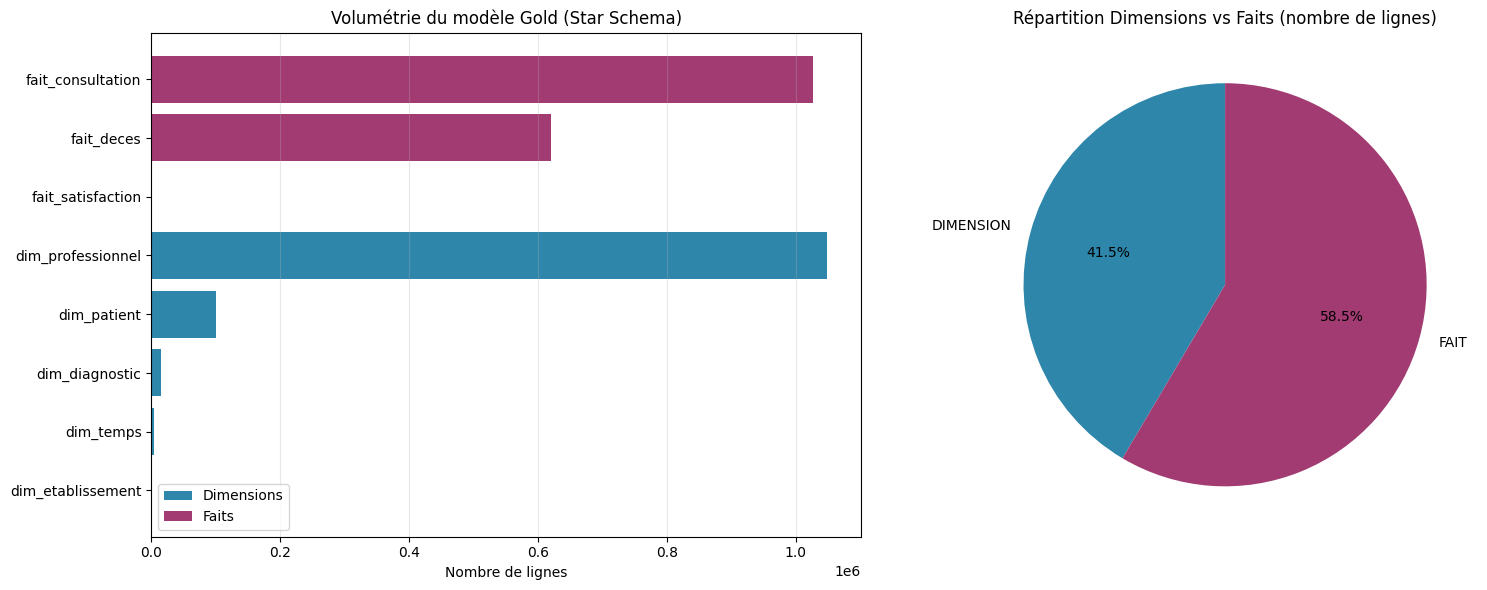


📊 Graphique sauvegardé: /home/jovyan/data/gold_star_schema_stats.png


In [29]:
# Visualisation du modèle
import matplotlib.pyplot as plt

if len(gold_tables) > 0:
    df_viz = pd.DataFrame(gold_tables)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Volumétries par table
    dims = df_viz[df_viz['type'] == 'DIMENSION'].sort_values('rows', ascending=True)
    faits = df_viz[df_viz['type'] == 'FAIT'].sort_values('rows', ascending=True)
    
    y_pos_dim = range(len(dims))
    y_pos_fait = range(len(dims), len(dims) + len(faits))
    
    ax1.barh(y_pos_dim, dims['rows'], color='#2E86AB', label='Dimensions')
    ax1.barh(y_pos_fait, faits['rows'], color='#A23B72', label='Faits')
    ax1.set_yticks(list(y_pos_dim) + list(y_pos_fait))
    ax1.set_yticklabels(list(dims['table']) + list(faits['table']))
    ax1.set_xlabel('Nombre de lignes')
    ax1.set_title('Volumétrie du modèle Gold (Star Schema)')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)
    
    # Répartition Dimensions vs Faits
    type_counts = df_viz.groupby('type')['rows'].sum()
    colors = ['#2E86AB', '#A23B72']
    ax2.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors)
    ax2.set_title('Répartition Dimensions vs Faits (nombre de lignes)')
    
    plt.tight_layout()
    plt.savefig('/home/jovyan/data/gold_star_schema_stats.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Graphique sauvegardé: /home/jovyan/data/gold_star_schema_stats.png")

---

## ✅ MODÈLE GOLD STAR SCHEMA TERMINÉ

### 🎯 Ce qui a été créé :

#### 🔷 Dimensions (5) :
- ✅ **dim_temps** : Dimension temporelle complète (2013-2025)
- ✅ **dim_patient** : Patients anonymisés (depuis Silver)
- ✅ **dim_diagnostic** : Codes diagnostics
- ✅ **dim_professionnel** : Professionnels de santé + spécialités
- ✅ **dim_etablissement** : Établissements de santé (données publiques)

#### 📊 Faits (3) :
- ✅ **fait_consultation** : Consultations médicales (partitionné année/mois)
- ✅ **fait_deces** : Décès 2019 anonymisés (partitionné année/mois)
- ✅ **fait_satisfaction** : Scores satisfaction E-Satis 2019 (partitionné année)

### 🚀 Optimisations appliquées :
- ✅ **Partitionnement temporel** (année/mois pour requêtes rapides)
- ✅ **Format Parquet** (compression ~10x vs CSV)
- ✅ **Adaptive Query Execution** (optimisations Spark automatiques)
- ✅ **Anonymisation RGPD** (hash SHA-256 des données sensibles)
- ✅ **Typage correct** (integer, double, date)
- ✅ **Dédoublonnage** (clés primaires uniques)

### 📊 Prochaine étape :
👉 **Notebook 04** : Benchmarks et mesure de performance

**Note importante** : Ce modèle Gold est construit depuis les données **Silver** (nettoyées et anonymisées), pas depuis Bronze. C'est le flux ETL correct !